In [26]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [27]:
# Define the file path and data types
file_path = "data/preprocessed_stock_data.csv"
dtype_dict = {'Ticker': 'category', 'Close': 'float32', 'Volume': 'float32', 'Price_Change': 'float32', 
              'Daily_Return': 'float32', 'Volatility': 'float32', 'MA_5': 'float32', 'MA_10': 'float32'}

# Load the data
df = pd.read_csv(
    file_path,
    na_values=['null'],
    index_col='Date',
    parse_dates=True,
    infer_datetime_format=True,
    dtype=dtype_dict
)

# Display basic information about the dataset
print("First few rows of dataset:")
print(df.head())

print("Dataset information:")
print(df.info())

# Check for the shape of the dataframe and missing values
print("Dataframe Shape: ", df.shape)
print("Null Values Present: ", df.isnull().values.any())


C:\Users\Khai Cao\AppData\Local\Temp\ipykernel_12044\2580883744.py:7: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(


First few rows of dataset:
           Ticker    Close   Volume  Price_Change  Daily_Return  Volatility  \
Date                                                                          
2014-01-24    BID  14.2723  8.41706       -0.1518      0.000000    0.052627   
2014-01-27    BID  13.9686  3.24091       -0.2278     -0.021279    0.037432   
2014-02-06    BID  13.3613  0.95959       -0.4555     -0.043476    0.038460   
2014-02-07    BID  12.6021  2.98760       -0.6074     -0.056821    0.057474   
2014-02-10    BID  12.9058  4.05209        0.3796      0.024099    0.060609   

                MA_5  MA_10  
Date                         
2014-01-24   0.00000    0.0  
2014-01-27   0.00000    0.0  
2014-02-06   0.00000    0.0  
2014-02-07   0.00000    0.0  
2014-02-10  13.42202    0.0  
Dataset information:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 68913 entries, 2014-01-24 to 2021-06-25
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        

C:\Users\Khai Cao\AppData\Local\Temp\ipykernel_12044\2389864304.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('Ticker')


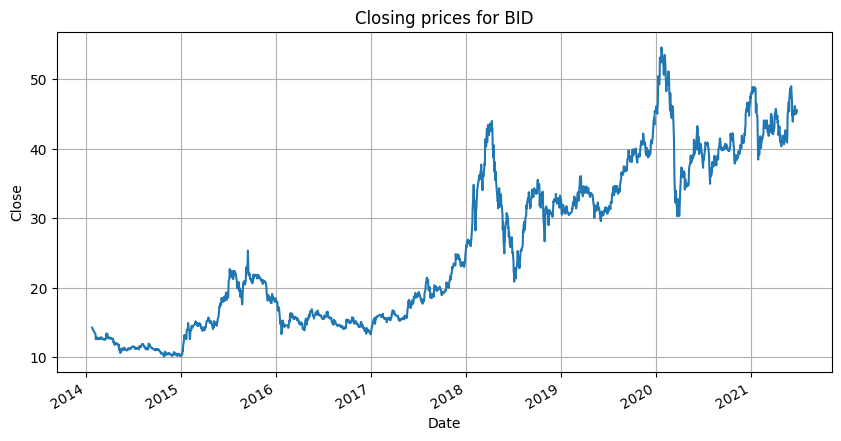

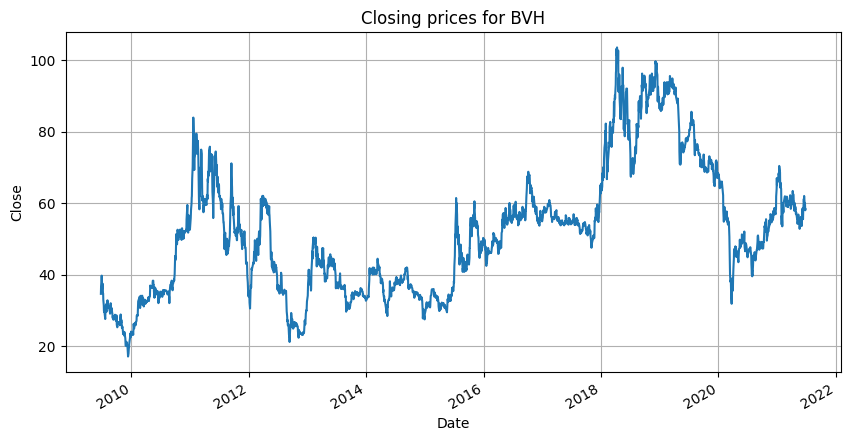

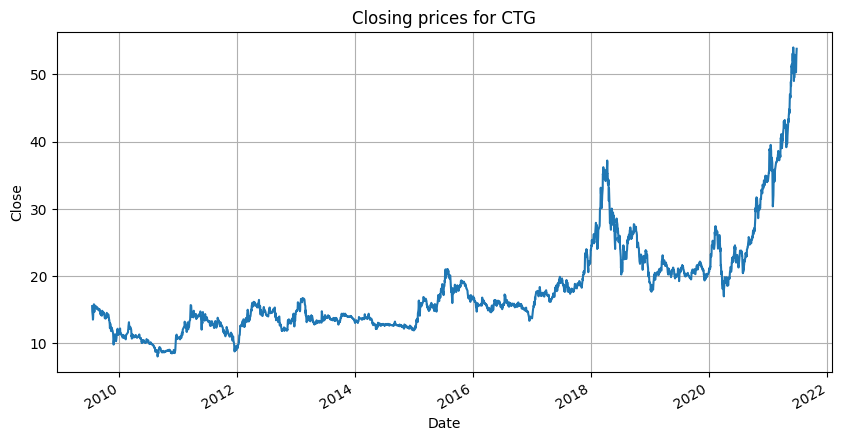

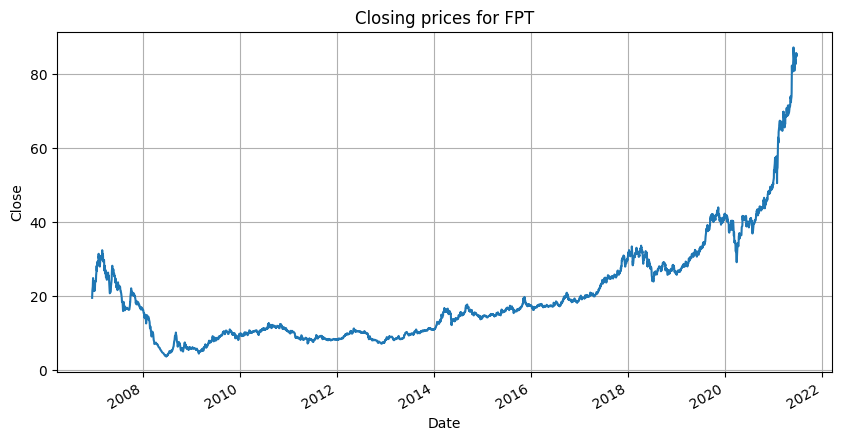

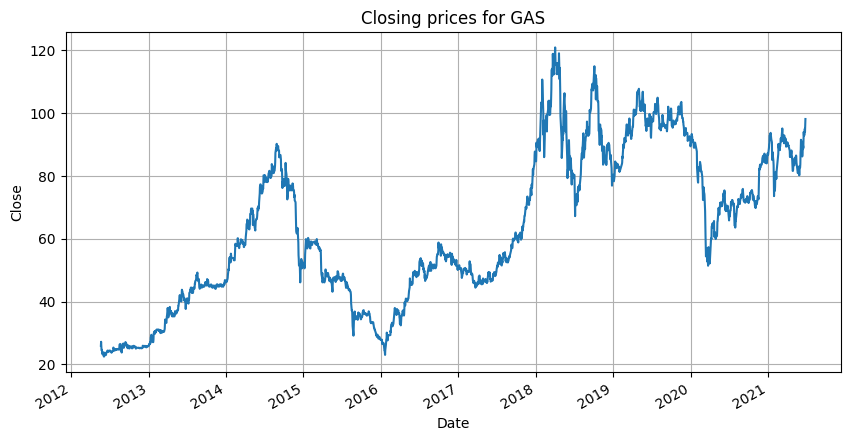

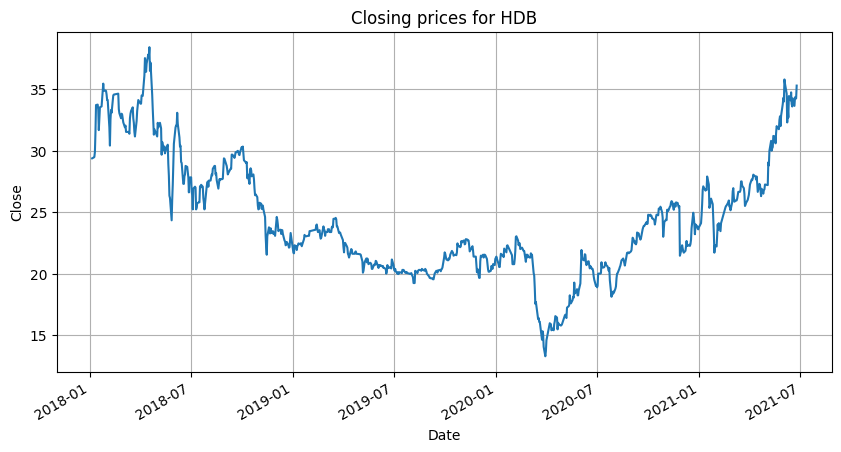

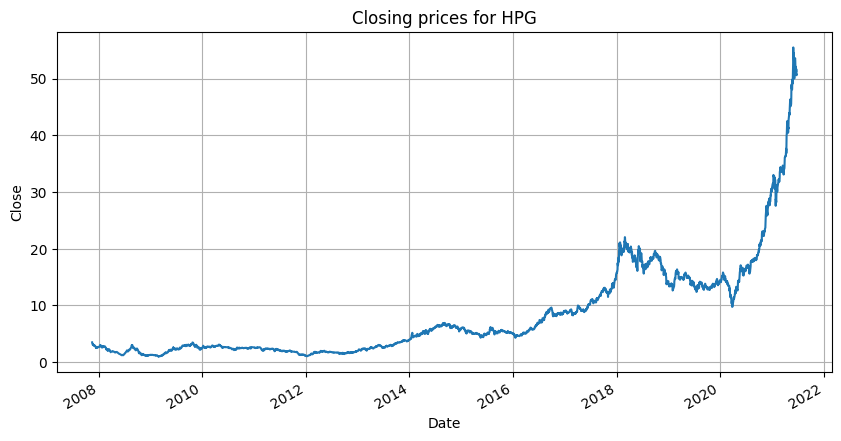

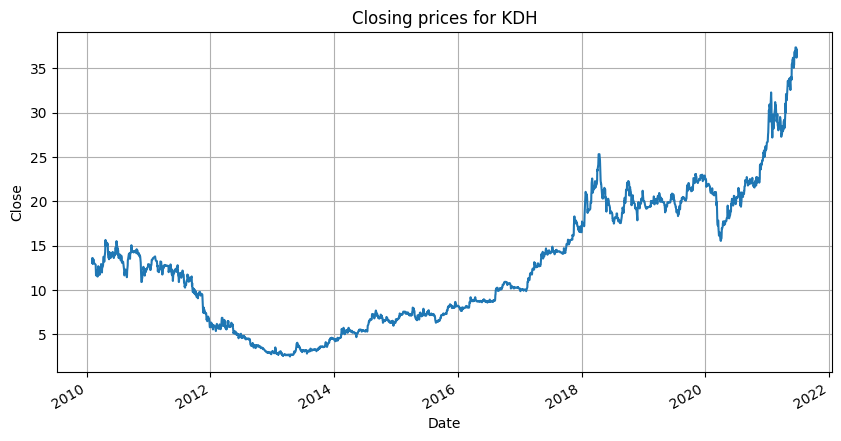

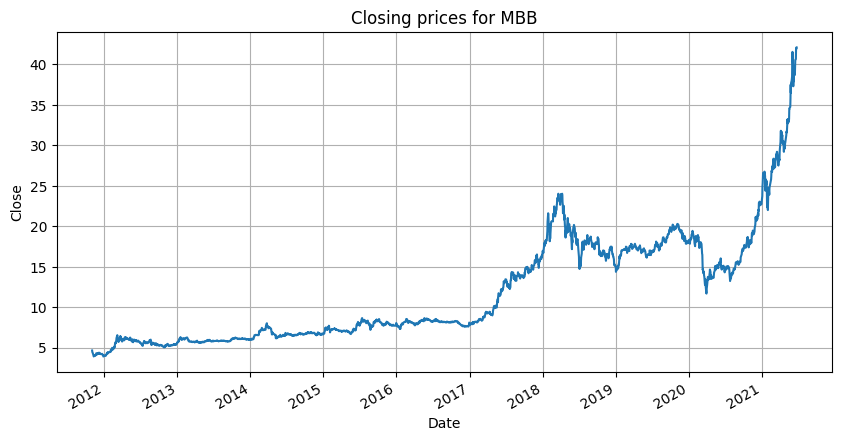

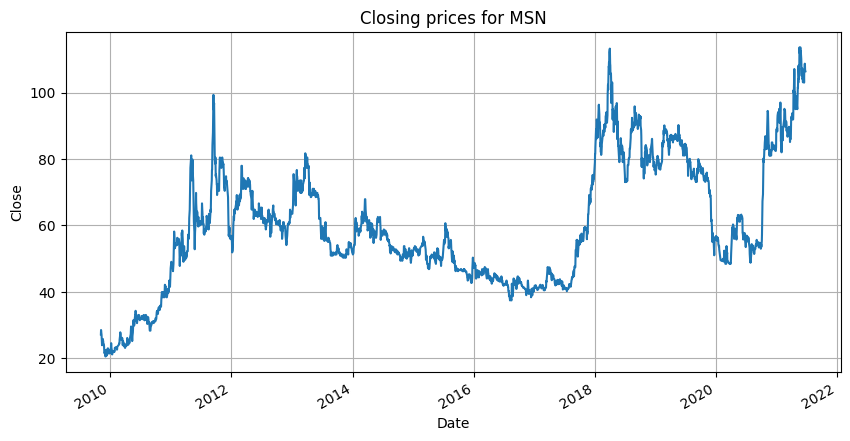

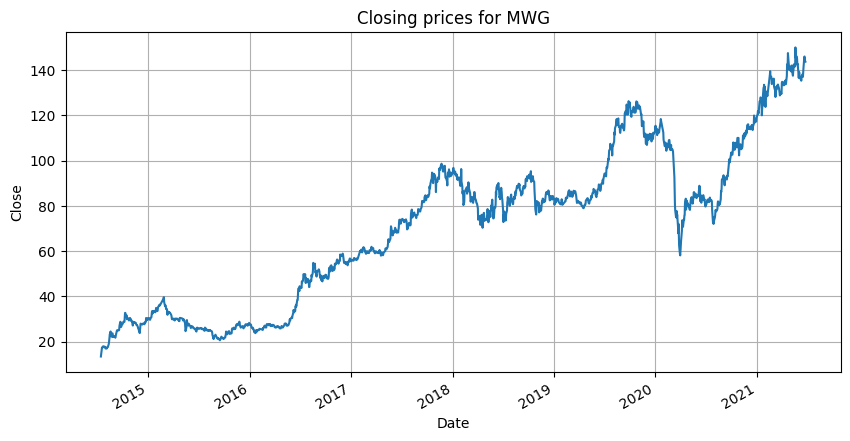

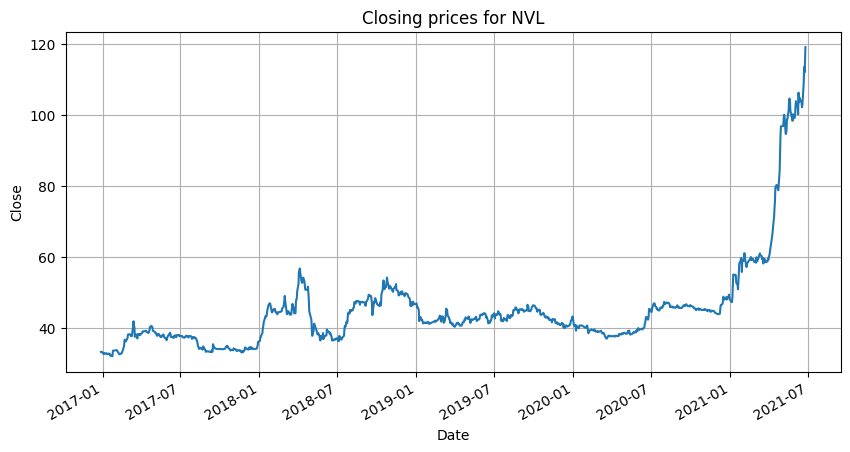

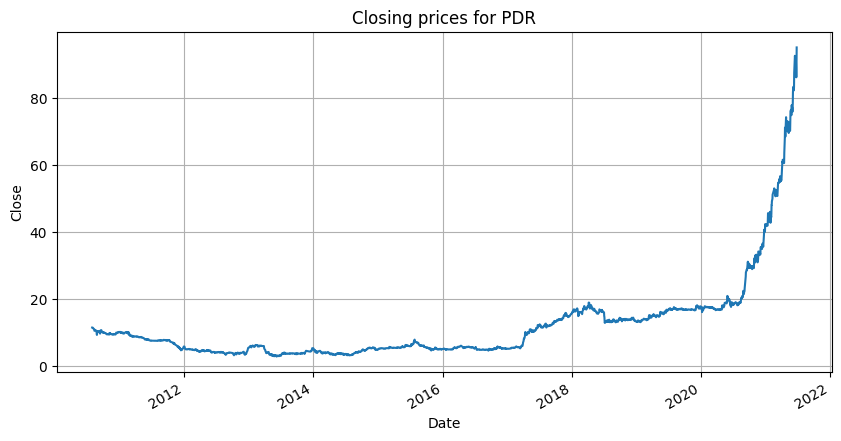

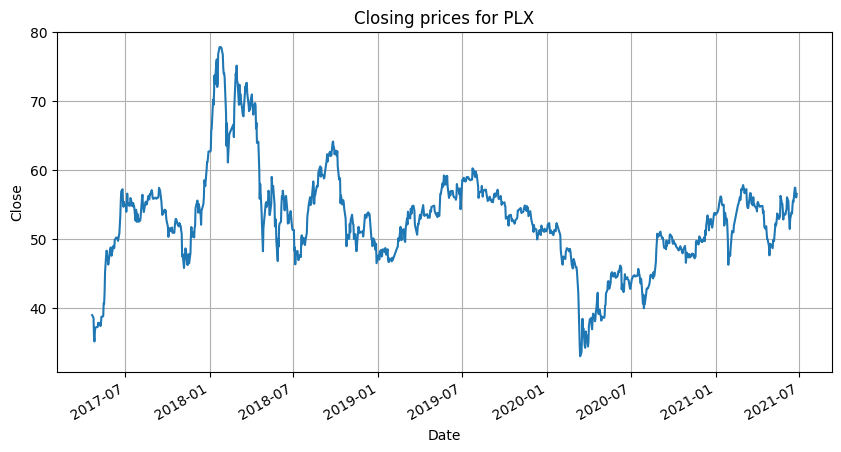

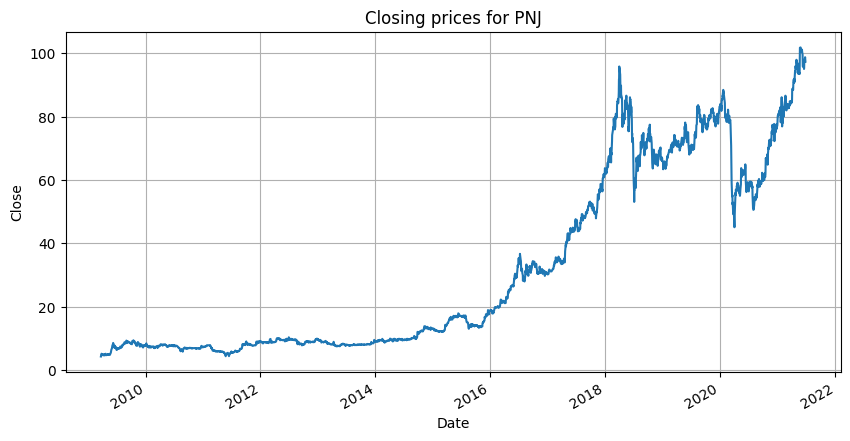

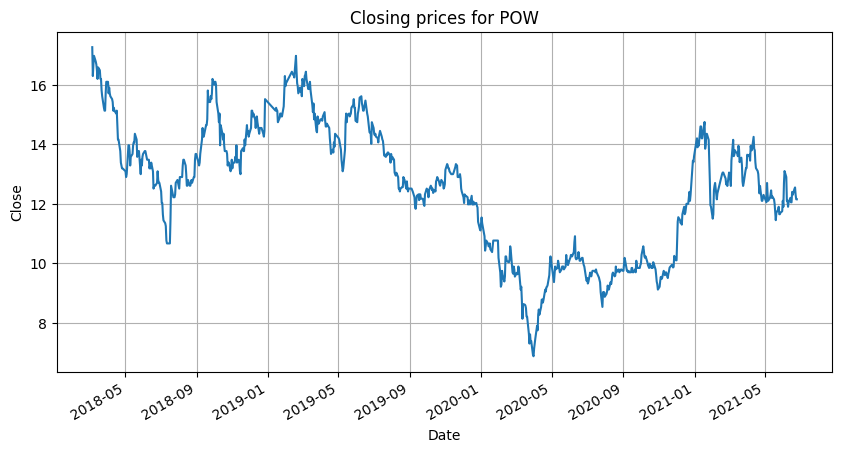

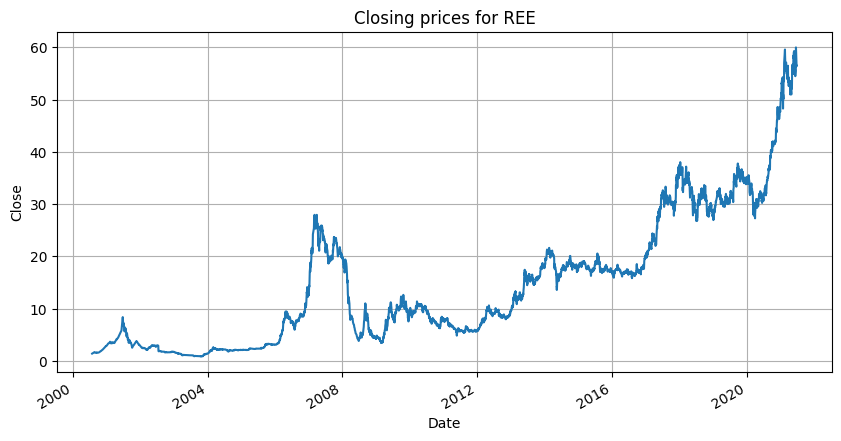

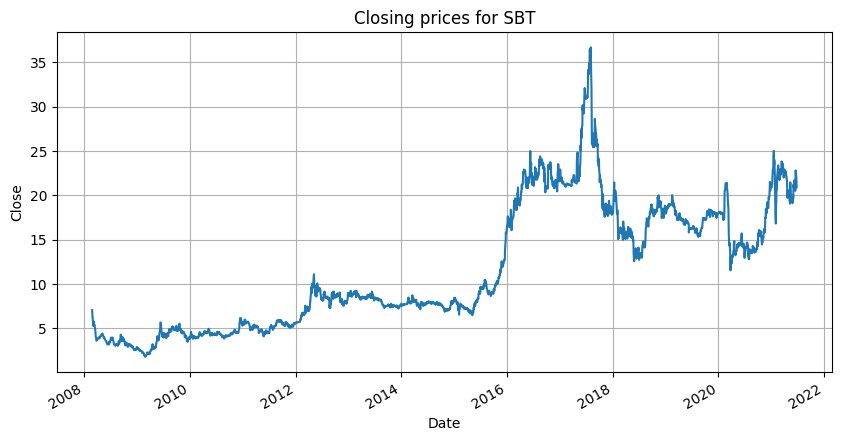

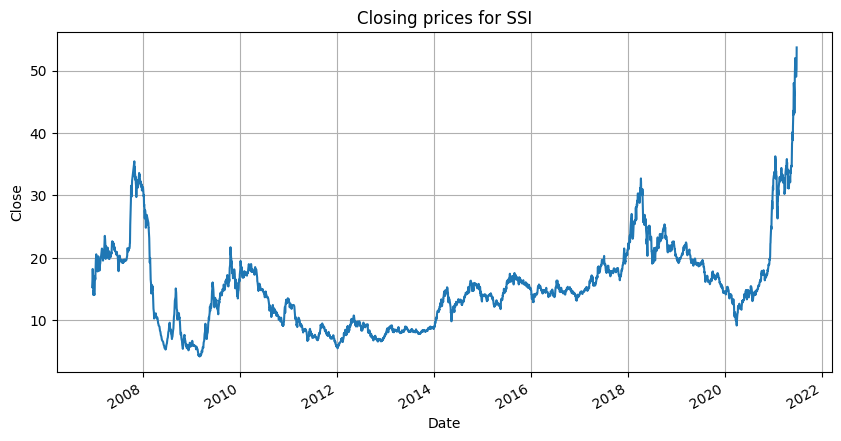

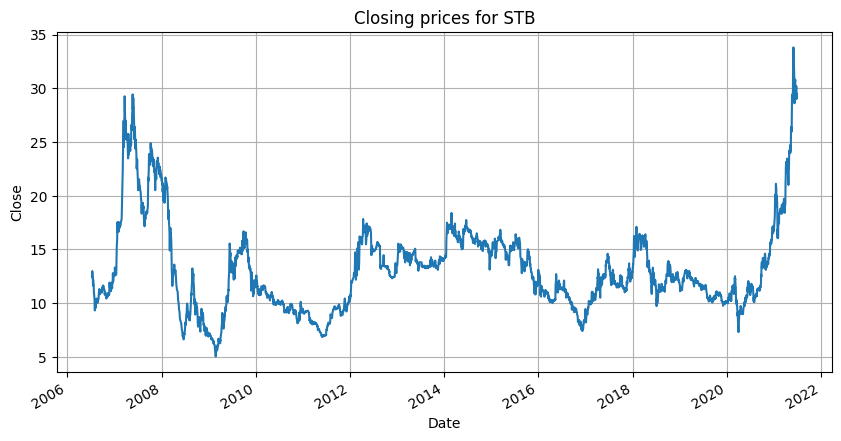

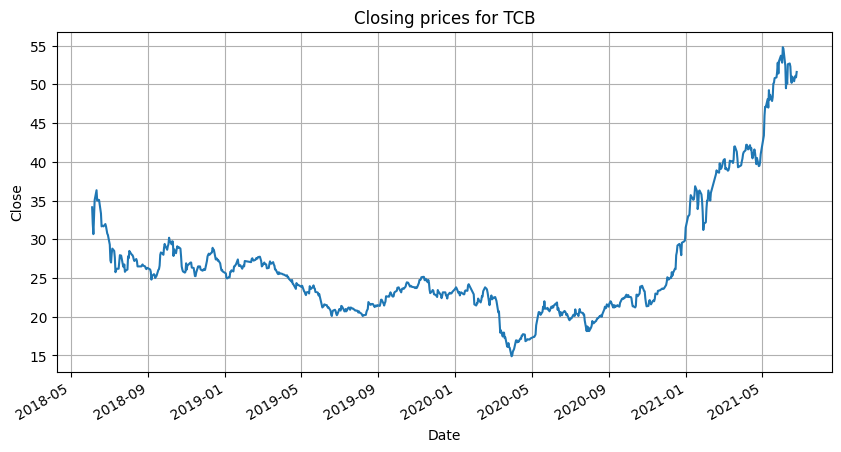

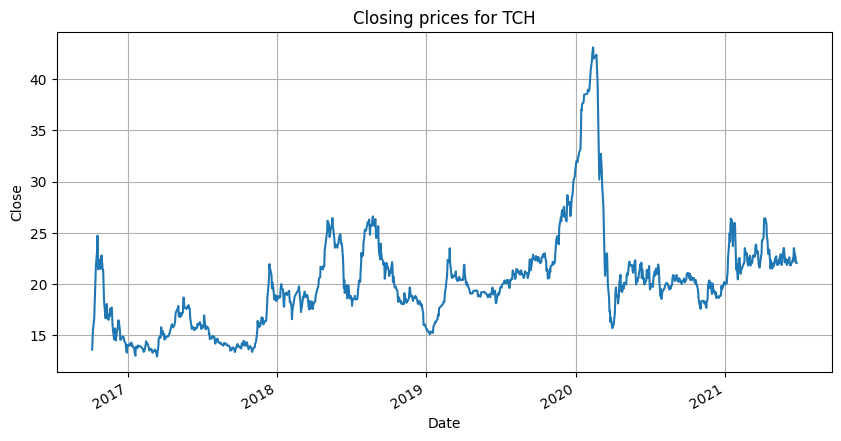

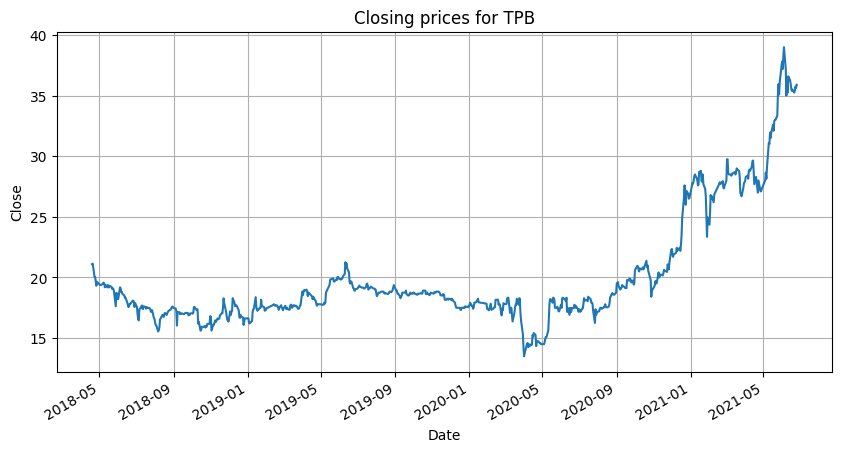

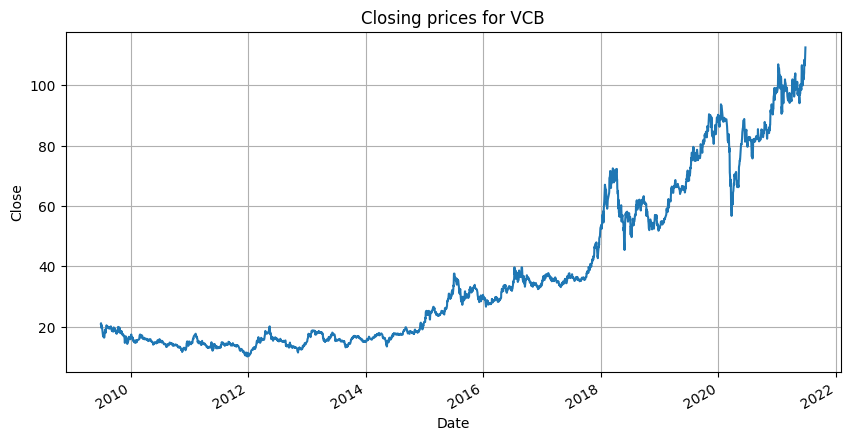

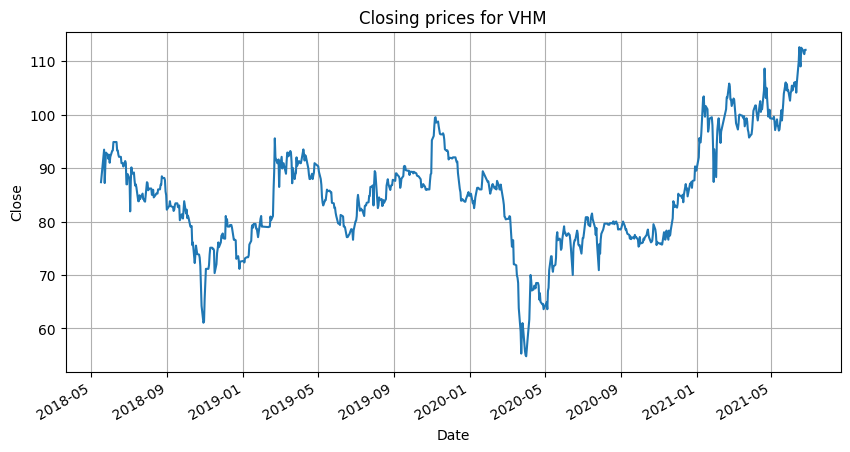

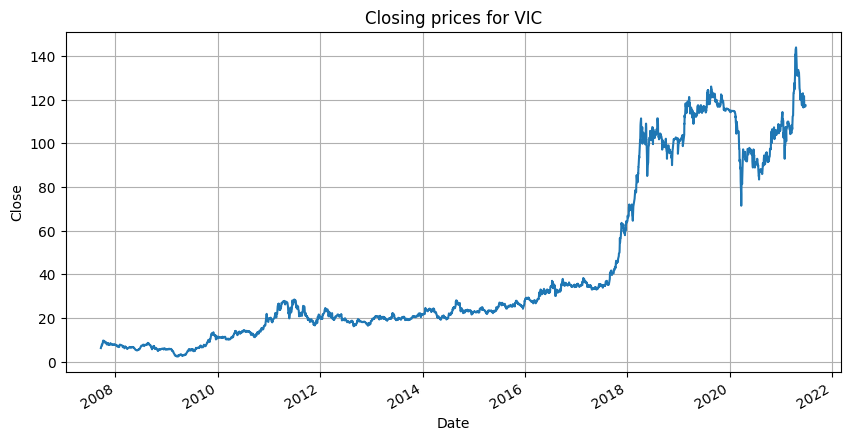

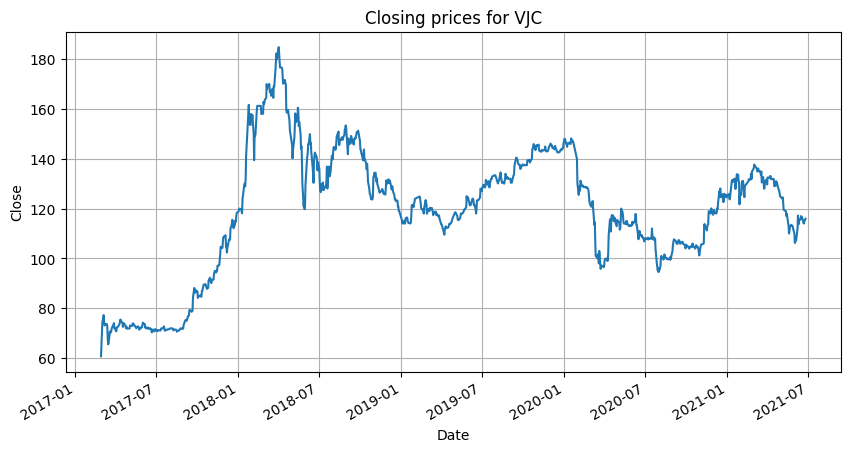

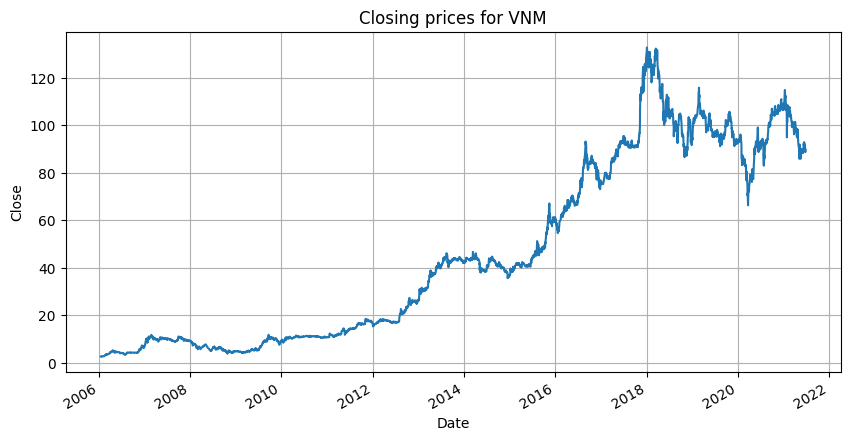

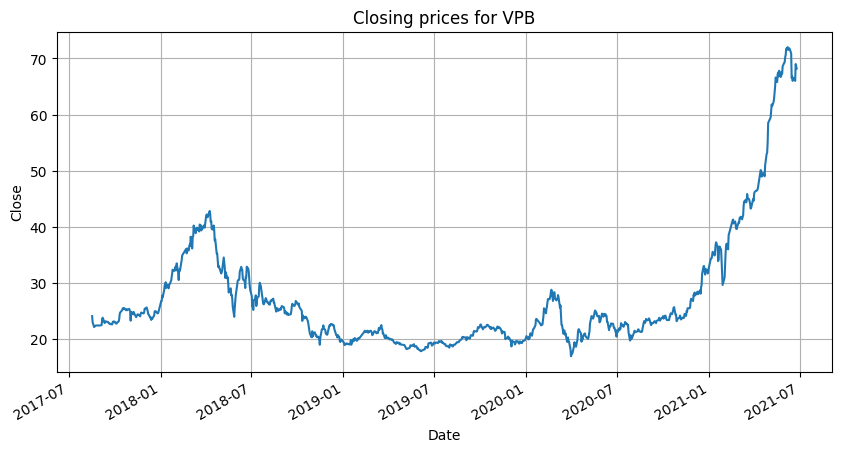

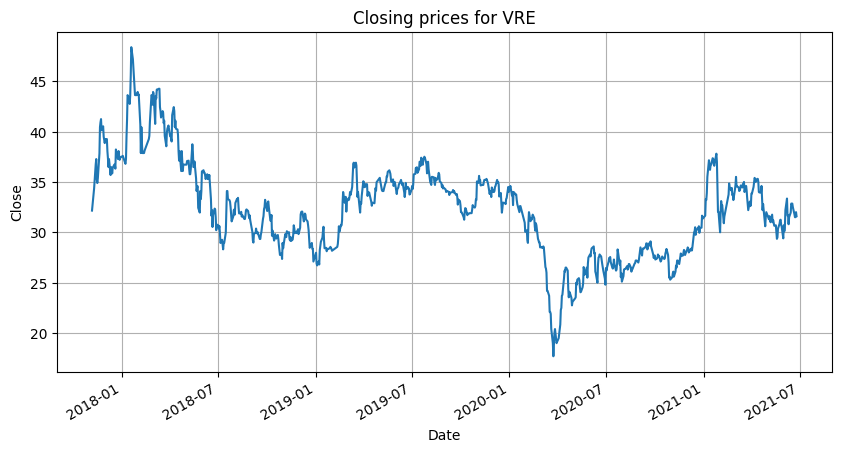

In [28]:
# Group the data by Ticker and plot the 'Close' prices
grouped = df.groupby('Ticker')

# Plot 'Close' values for each 'Ticker'
for ticker, data in grouped:
    plt.figure(figsize=(10, 5))  # Set figure size for each plot
    data['Close'].plot(title=f"Closing prices for {ticker}")
    plt.xlabel("Date")
    plt.ylabel("Close")
    plt.grid()
    plt.show()


In [29]:
# Check for NaN or infinite values
print("Checking for NaN or infinite values in the data...")
print(df[features].isnull().sum())  # Check for NaN values
print((df[features] == np.inf).sum())  # Check for infinity values
print((df[features] == -np.inf).sum())  # Check for negative infinity values

# Replace or drop NaN or infinite values
df[features] = df[features].replace([np.inf, -np.inf], np.nan)  # Replace infinities with NaN
df = df.dropna(subset=features)  # Drop rows with NaN values

# Now scale the data
scaled_data_list = []  # Use a list to store data for faster concatenation

for ticker, group in df.groupby('Ticker'):
    # Scale features within each ticker group
    scaled_features = scaler.fit_transform(group[features])
    
    # Create a DataFrame for the scaled features
    scaled_group = pd.DataFrame(
        data=scaled_features,
        columns=features,
        index=group.index
    )
    
    # Add the 'Ticker' column back to the scaled group
    scaled_group['Ticker'] = ticker
    
    # Append the scaled group to the list
    scaled_data_list.append(scaled_group)

# Concatenate all scaled groups at once
scaled_data = pd.concat(scaled_data_list)

# Display the first few rows of the scaled data
print("Scaled data (first few rows):")
print(scaled_data.head())


C:\Users\Khai Cao\AppData\Local\Temp\ipykernel_12044\112725907.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for ticker, group in df.groupby('Ticker'):


ValueError: Input X contains infinity or a value too large for dtype('float32').

In [24]:
# Sort the DataFrame by 'Ticker' and 'Date' to maintain time order
df = df.sort_values(by=['Ticker', 'Date'])

# Initialize TimeSeriesSplit with 10 splits
timesplit = TimeSeriesSplit(n_splits=10)

# Initialize lists to store the train and test data for each split
X_train_list, X_test_list, y_train_list, y_test_list = [], [], [], []

# Perform time series split
for train_index, test_index in timesplit.split(df):
    # Use loc instead of iloc for clarity with index handling
    train_data, test_data = df.iloc[train_index], df.iloc[test_index]
    
    # Extract features and target variables for train and test
    X_train_list.append(train_data[features].values)  # Convert to NumPy for efficiency
    X_test_list.append(test_data[features].values)
    y_train_list.append(train_data[output_var].values)
    y_test_list.append(test_data[output_var].values)

# Concatenate all splits into single arrays
X_train_all = np.vstack(X_train_list)  # Stack arrays vertically
X_test_all = np.vstack(X_test_list)
y_train_all = np.concatenate(y_train_list)
y_test_all = np.concatenate(y_test_list)

# Print the shapes to verify
print("X_train_all shape:", X_train_all.shape)
print("X_test_all shape:", X_test_all.shape)
print("y_train_all shape:", y_train_all.shape)
print("y_test_all shape:", y_test_all.shape)


In [ ]:
# Define the LSTM model
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, X_train_all.shape[2]), activation='relu', return_sequences=False))
lstm.add(Dense(1))

# Compile the model
lstm.compile(loss='mean_squared_error', optimizer='adam')

# Display the model summary
plot_model(lstm, show_shapes=True, show_layer_names=True)
lstm.summary()


In [ ]:
# Add callbacks for optimization
early_stopping = EarlyStopping(
    monitor='loss', 
    patience=5,  # Stop training if loss doesn't improve for 5 epochs
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='loss', 
    factor=0.5, 
    patience=3,  # Reduce learning rate if loss doesn't improve for 3 epochs
    min_lr=1e-6
)

# Train the model with fewer epochs and callbacks
history = lstm.fit(
    X_train_all, 
    y_train_all, 
    epochs=50,  # Reduce epochs
    batch_size=16,  # Larger batch size for faster training
    verbose=1, 
    shuffle=False, 
    callbacks=[early_stopping, reduce_lr]
)


In [ ]:
# LSTM Prediction
y_pred_all = lstm.predict(X_test_all, batch_size=8, verbose=1)

# Flatten the predicted values and actual values for comparison
y_pred_all = y_pred_all.flatten()  # Flatten predictions
y_test_all = y_test_all.flatten()  # Flatten true values (if necessary)

# Print the first few predictions and corresponding actual values for verification
print("First 10 predictions:", y_pred_all[:10])
print("First 10 actual values:", y_test_all[:10])

# Calculate performance metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test_all, y_pred_all)
mae = mean_absolute_error(y_test_all, y_pred_all)
r2 = r2_score(y_test_all, y_pred_all)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2 Score):", r2)


In [ ]:
# Create a map of indices for each ticker
ticker_indices = {}
start_index = 0
for ticker, group in grouped:
    group_len = len(group)
    ticker_indices[ticker] = range(start_index, start_index + group_len)
    start_index += group_len

# LSTM Prediction
y_pred_all = lstm.predict(X_test_all, batch_size=8, verbose=0).flatten()  # Flatten predictions

# Plot Predicted vs True for each ticker
for ticker, indices in ticker_indices.items():
    # Extract valid indices (ensure they are within the test set range)
    valid_indices = [idx for idx in indices if idx < len(y_test_all)]

    if not valid_indices:
        print(f"No valid indices for ticker {ticker}. Skipping.")
        continue

    # Extract true and predicted values for the current ticker
    y_test_ticker = y_test_all[valid_indices]
    y_pred_ticker = y_pred_all[valid_indices]

    # Plot the true and predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_ticker, label=f'True Value for {ticker}', color='blue', linestyle='--')
    plt.plot(y_pred_ticker, label=f'LSTM Predicted Value for {ticker}', color='red', linestyle='-')
    plt.title(f"Prediction by LSTM for {ticker}")
    plt.xlabel('Time Scale')
    plt.ylabel('Scaled Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
# LSTM Prediction
# Use the trained model to predict on the test set
y_pred_all = lstm.predict(X_test_all, batch_size=8, verbose=1)

# Flatten the predicted values and actual values for comparison
y_pred_all = y_pred_all.flatten()  # Flatten predictions
y_test_all = y_test_all.flatten()  # Flatten true values (if necessary)

# Print the first few predictions and corresponding actual values for verification
print("First 10 predictions:", y_pred_all[:10])
print("First 10 actual values:", y_test_all[:10])

# Calculate performance metrics (Optional: Evaluate the model's performance)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test_all, y_pred_all)
mae = mean_absolute_error(y_test_all, y_pred_all)
r2 = r2_score(y_test_all, y_pred_all)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2 Score):", r2)

In [ ]:
# Create a map of indices for each ticker
ticker_indices = {}
start_index = 0
for ticker, group in grouped:
    group_len = len(group)
    ticker_indices[ticker] = range(start_index, start_index + group_len)
    start_index += group_len

# LSTM Prediction
y_pred_all = lstm.predict(X_test_all, batch_size=8, verbose=0).flatten()  # Flatten predictions

# Plot Predicted vs True for each ticker
for ticker, indices in ticker_indices.items():
    # Extract valid indices (ensure they are within the test set range)
    valid_indices = [idx for idx in indices if idx < len(y_test_all)]

    if not valid_indices:
        print(f"No valid indices for ticker {ticker}. Skipping.")
        continue

    # Extract true and predicted values for the current ticker
    y_test_ticker = y_test_all[valid_indices]
    y_pred_ticker = y_pred_all[valid_indices]

    # Plot the true and predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_ticker, label=f'True Value for {ticker}', color='blue', linestyle='--')
    plt.plot(y_pred_ticker, label=f'LSTM Predicted Value for {ticker}', color='red', linestyle='-')
    plt.title(f"Prediction by LSTM for {ticker}")
    plt.xlabel('Time Scale')
    plt.ylabel('Scaled Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()